In [2]:
import json
from itertools import islice
from pathlib import Path
from typing import Callable

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from jaxtyping import Float, Int
from n2g import FeatureModel, NeuronStats, Tokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from torch import Tensor
from transformer_lens import HookedTransformer

from thesis.device import Device
from thesis.mas import WeightedSamplesStore, html
from thesis.sae.sae import SparseAutoencoder

/home/user/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = Device.get()
model = HookedTransformer.from_pretrained("gelu-1l")
tokenizer = Tokenizer(model)
sae = SparseAutoencoder.from_hf("NeelNanda/sparse_autoencoder", "25.pt", "blocks.0.mlp.hook_post", device)

out_path = Path("../outputs/sandbox/sae")
out_path.mkdir(parents=True, exist_ok=True)

Loaded pretrained model gelu-1l into HookedTransformer


In [4]:
N_MLP = 2048
N_SAE = 2048 * 8
N_TOTAL = N_MLP + N_SAE
N_BOOTSTRAP = 1000
FIRING_THRESHOLD_BIN = 4  # Should match all bins with activation < 0.5

outputs_path = Path("../outputs")
n2g_dir = outputs_path / "gelu-1l_sae_n2g"
stats_path = n2g_dir / "stats.json"

with stats_path.open("r", encoding="utf-8") as f:
    stats_json = json.load(f)
    stats = [NeuronStats.from_dict(neuron_stats) for neuron_stats in stats_json]

assert len(stats) == N_TOTAL, f"Expected {N_TOTAL} stats, got {len(stats)}"

device = Device.get()

mas_path = Path("../outputs/gelu-1l_sae_store.zip")
mas_store = WeightedSamplesStore.load(mas_path, device)
mas_samples = mas_store.feature_samples()
mas_activations = mas_store.feature_activations()

n2gs_path = n2g_dir / "models" / "all_models.bin"
with n2gs_path.open("rb") as f:
    bin = f.read()
    n2gs = FeatureModel.list_from_bin(tokenizer, bin)


def get_stats(neuron_stats: list[NeuronStats], get: Callable[[NeuronStats], float]) -> list[float]:
    return [get(neuron) for neuron in neuron_stats]


def stats_df(
    stats: list[NeuronStats], feature_densities: Int[Tensor, "num_features num_activation_bins"], group: str
) -> pd.DataFrame:
    densities = feature_densities.cpu().numpy()
    firing_densities = densities[:, FIRING_THRESHOLD_BIN:].sum(axis=1) / densities.sum(axis=1)

    return pd.DataFrame(
        {
            "accuracy": get_stats(stats, lambda x: x.accuracy),
            "firing_recall": get_stats(stats, lambda x: x.firing.recall),
            "firing_precision": get_stats(stats, lambda x: x.firing.precision),
            "firing_f1": get_stats(stats, lambda x: x.firing.f1_score),
            "firing_count": get_stats(stats, lambda x: x.firing.count),
            "non_firing_recall": get_stats(stats, lambda x: x.non_firing.recall),
            "non_firing_precision": get_stats(stats, lambda x: x.non_firing.precision),
            "non_firing_f1": get_stats(stats, lambda x: x.non_firing.f1_score),
            "non_firing_count": get_stats(stats, lambda x: x.non_firing.count),
            "density": firing_densities,
            "log_density": np.log10(firing_densities),
            "group": [group] * len(stats),
        }
    )


mlp_df = stats_df(stats[:N_MLP], mas_store.feature_densities[:N_MLP], "mlp")
sae_df = stats_df(stats[N_MLP:], mas_store.feature_densities[N_MLP:], "sae")

df = pd.concat([mlp_df, sae_df])

group_counts = {
    "mlp": df[df["group"] == "mlp"].shape[0],
    "sae": df[df["group"] == "sae"].shape[0],
}

/tmp/ipykernel_24100/1285745980.py:52: RuntimeWarning: divide by zero encountered in log10
  "log_density": np.log10(firing_densities),


In [5]:
def mean_similarity(directions: Float[Tensor, "_ num_neurons"]) -> Float:
    assert directions.shape[1] == 2048
    directions = directions / torch.linalg.vector_norm(directions, dim=1, keepdim=True)
    similarities = torch.matmul(directions, directions.T)
    similarities.diagonal().fill_(0)
    return torch.mean(similarities)

In [6]:
sae_directions_cuda = sae._w_enc.T
random_directions_cuda = torch.randn_like(sae_directions_cuda)
sae_directions_cuda /= torch.linalg.vector_norm(sae_directions_cuda, dim=1, keepdim=True)
random_directions_cuda /= torch.linalg.vector_norm(random_directions_cuda, dim=1, keepdim=True)

sae_similarities = torch.matmul(sae_directions_cuda, sae_directions_cuda.T)
random_similarities = torch.matmul(random_directions_cuda, random_directions_cuda.T)

In [7]:
print(f"SAE similarity mean: {mean_similarity(sae_directions_cuda).item()}")
print(f"Randoms similarity mean: {mean_similarity(random_directions_cuda).item()}")

SAE similarity mean: 0.3640173077583313
Randoms similarity mean: 3.8958285131229786e-07


<Axes: >

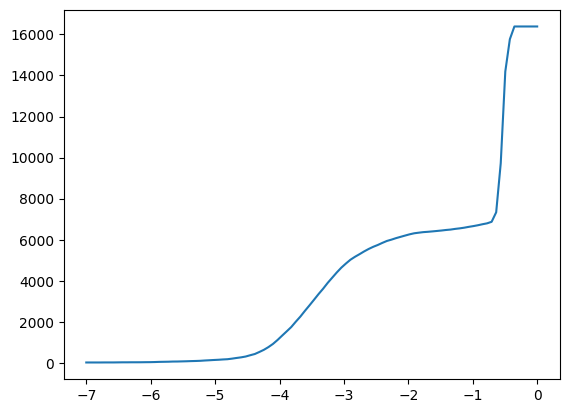

In [8]:
xs = np.linspace(-7, 0, 100)
ys = np.array([len(sae_df[sae_df["log_density"] < threshold]) for threshold in xs])
sns.lineplot(x=xs, y=ys)

Mean distance from mean: 0.14385747909545898
Num directions: 9830
Mean cosine similarity: 0.9720200896263123


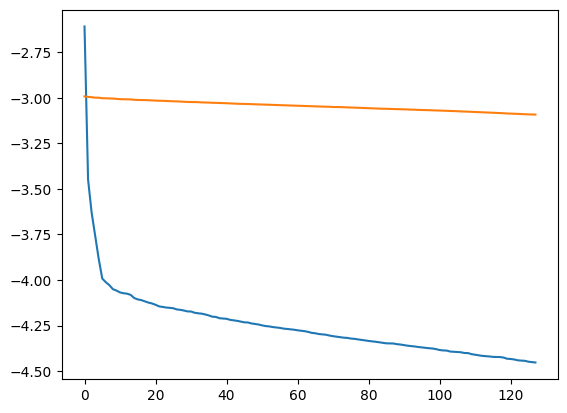

Variance explained by first 20 components: 0.004633923526853323


In [9]:
a = -4.5
b = -1.2
all = sae_df.index
low = sae_df.index[sae_df["log_density"] < a]
mid = sae_df.index[(sae_df["log_density"] >= a) & (sae_df["log_density"] < b)]
high = sae_df.index[sae_df["log_density"] >= b]
good = sae_df.index[sae_df["firing_f1"] > 0.9]

indices = high

indices_cuda = torch.tensor(indices, device=device.torch())
directions_cuda = sae_directions_cuda[indices_cuda]

directions = directions_cuda.cpu().numpy()
sae_pca = PCA(n_components=128)
# get the pca directions and magnitudes
sae_pca.fit(directions)
sae_pca_directions = sae_pca.components_
sae_pca_magnitudes = sae_pca.explained_variance_
sae_pca_transformed = sae_pca.transform(directions)

random_directions = np.random.randn(len(indices), 2048)
random_directions /= np.linalg.norm(random_directions, axis=1, keepdims=True)
random_pca = PCA(n_components=128)
random_pca.fit(random_directions)
random_pca_directions = random_pca.components_
random_pca_magnitudes = random_pca.explained_variance_
random_pca_transformed = random_pca.transform(random_directions)

dense_mean = directions_cuda.mean(dim=0, keepdim=True)
mean_dist_from_mean = torch.linalg.vector_norm(directions_cuda - dense_mean, dim=1).mean().item()
print(f"Mean distance from mean: {mean_dist_from_mean}")

print(f"Num directions: {len(directions)}")
print(f"Mean cosine similarity: {mean_similarity(directions_cuda)}")
xlim = 128
sns.lineplot(x=range(0, xlim), y=np.log10(sae_pca_magnitudes)[:xlim])
sns.lineplot(x=range(0, xlim), y=np.log10(random_pca_magnitudes)[:xlim])
plt.show()
print(f"Variance explained by first 20 components: {sae_pca_magnitudes[:20].sum()}")

In [10]:
high_dir = out_path / "high"
high_dir.mkdir(exist_ok=True, parents=True)
for index in islice(high + 2048, 10):
    n2g_model: FeatureModel = n2gs[index]

    graph = graphviz.Source(n2g_model.graphviz())
    print(graph)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (high_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_8 {
186[label="Sh",fillcolor="#b5b5ff"];
};
subgraph cluster_7 {
120[label="one",fillcolor="#9e9eff"];
};
subgraph cluster_6 {
105[label="
            
           ",fillcolor="#0000ff"];
106[label="
            
           ",fillcolor="#0000ff"];
107[label="
            
           ",fillcolor="#0000ff"];
108[label="
            
           ",fillcolor="#0000ff"];
109[label="
            
           ",fillcolor="#1e1eff"];
110[label="
            
           ",fillcolor="#0000ff"];
111[label="
            
           ",fillcolor="#0000ff"];
112[label="()",fillcolor="#1212ff"];
113[label="_",fillcolor="#2a2aff"];
187[label="rand",fillcolor="#0000ff"];
159[label="be",fillcolor="#2727ff"];
};
subgraph cluster_5 {
84[label="

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_9 {
675[label=" the",fillcolor="#0202ff"];
676[label=" and",fillcolor="#0303ff"];
677[label=" another",fillcolor="#0202ff"];
678[label=" released",fillcolor="#0404ff"];
679[label=" album",fillcolor="#0303ff"];
};
subgraph cluster_8 {
634[label=" the",fillcolor="#0000ff"];
635[label=" and",fillcolor="#0000ff"];
636[label=" another",fillcolor="#0000ff"];
409[label=" and",fillcolor="#0000ff"];
402[label=" Sleep",fillcolor="#acacff"];
};
subgraph cluster_7 {
336[label=" and",fillcolor="#0000ff"];
338[label="Paper",fillcolor="#0000ff"];
344[label=" the",fillcolor="#0000ff"];
345[label=" the",fillcolor="#0000ff"];
346[label=" the",fillcolor="#0000ff"];
347[label=" the",fillcolor="#0000ff"];
348[label=" the",fillcolor="#0000ff"

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_7 {
120[label="int",fillcolor="#0303ff"];
176[label="bone",fillcolor="#0000ff"];
209[label=".",fillcolor="#1a1aff"];
};
subgraph cluster_6 {
103[label="(",fillcolor="#0000ff"];
104[label="_",fillcolor="#3131ff"];
122[label="A",fillcolor="#5a5aff"];
113[label=" v",fillcolor="#0000ff"];
114[label="1",fillcolor="#0000ff"];
180[label="be",fillcolor="#2929ff"];
};
subgraph cluster_5 {
91[label="1",fillcolor="#0000ff"];
92[label="top",fillcolor="#2121ff"];
106[label="1",fillcolor="#2d2dff"];
107[label="C",fillcolor="#2323ff"];
108[label="V",fillcolor="#2323ff"];
109[label="n",fillcolor="#2323ff"];
110[label="root",fillcolor="#2222ff"];
111[label="bone",fillcolor="#2323ff"];
96[label="node",fillcolor="#0000ff"];
97[label="]",fi

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_10 {
407[label="Paper",fillcolor="#ffffff"];
};
subgraph cluster_9 {
286[label=" tunes",fillcolor="#8383ff"];
417[label=" the",fillcolor="#0a0aff"];
418[label=" and",fillcolor="#0d0dff"];
419[label=" another",fillcolor="#0909ff"];
420[label=" released",fillcolor="#1010ff"];
421[label=" album",fillcolor="#0c0cff"];
};
subgraph cluster_8 {
409[label=" the",fillcolor="#0000ff"];
410[label=" and",fillcolor="#0000ff"];
411[label=" another",fillcolor="#0000ff"];
269[label=" and",fillcolor="#9d9dff"];
275[label=" Sleep",fillcolor="#adadff"];
};
subgraph cluster_7 {
241[label=" and",fillcolor="#0000ff"];
243[label="Paper",fillcolor="#0000ff"];
251[label=" a",fillcolor="#2b2bff"];
374[label=" and",fillcolor="#3333ff"];
257[label=

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_7 {
141[label=".",fillcolor="#1919ff"];
};
subgraph cluster_6 {
92[label="A",fillcolor="#5151ff"];
86[label="2",fillcolor="#0000ff"];
126[label="be",fillcolor="#2121ff"];
};
subgraph cluster_5 {
79[label="1",fillcolor="#2323ff"];
80[label="C",fillcolor="#1616ff"];
81[label="V",fillcolor="#1616ff"];
82[label="n",fillcolor="#1616ff"];
83[label="root",fillcolor="#1616ff"];
84[label="bone",fillcolor="#1616ff"];
73[label="]",fillcolor="#0000ff"];
76[label="ob",fillcolor="#3737ff"];
};
subgraph cluster_4 {
61[label="SE",fillcolor="#2929ff"];
71[label="_",fillcolor="#1c1cff"];
116[label="=",fillcolor="#0000ff"];
65[label=" +",fillcolor="#0000ff"];
109[label=".",fillcolor="#0000ff"];
68[label="ead",fillcolor="#0000ff"];
};
subgr

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_7 {
162[label="rand",fillcolor="#0000ff"];
};
subgraph cluster_6 {
85[label="_",fillcolor="#3f3fff"];
86[label="0",fillcolor="#0000ff"];
165[label="rand",fillcolor="#0000ff"];
};
subgraph cluster_5 {
71[label="top",fillcolor="#3333ff"];
72[label=" take",fillcolor="#3c3cff"];
73[label=" take",fillcolor="#2d2dff"];
74[label=" take",fillcolor="#3f3fff"];
75[label="0",fillcolor="#0000ff"];
76[label="0",fillcolor="#0b0bff"];
166[label="A",fillcolor="#0000ff"];
125[label="be",fillcolor="#3131ff"];
79[label=" {",fillcolor="#3e3eff"];
80[label=" {",fillcolor="#3838ff"];
81[label=" {",fillcolor="#4f4fff"];
82[label=" {",fillcolor="#3333ff"];
83[label=" {",fillcolor="#5454ff"];
84[label=" {",fillcolor="#5454ff"];
};
subgraph clust

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_7 {
175[label="bone",fillcolor="#0000ff"];
207[label=".",fillcolor="#1b1bff"];
};
subgraph cluster_6 {
130[label="_",fillcolor="#3333ff"];
142[label="A",fillcolor="#4848ff"];
137[label=" v",fillcolor="#0000ff"];
138[label="1",fillcolor="#0000ff"];
206[label="A",fillcolor="#0000ff"];
140[label="
               ",fillcolor="#3a3aff"];
178[label="be",fillcolor="#2c2cff"];
};
subgraph cluster_5 {
110[label="top",fillcolor="#2929ff"];
111[label=")]",fillcolor="#2626ff"];
131[label="1",fillcolor="#1414ff"];
132[label="C",fillcolor="#0505ff"];
133[label="V",fillcolor="#0505ff"];
134[label="n",fillcolor="#0505ff"];
135[label="root",fillcolor="#0505ff"];
136[label="bone",fillcolor="#0505ff"];
113[label="Group",fillcolor="#3535ff"

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_16 {
493[label=" tob",fillcolor="#0000ff"];
};
subgraph cluster_15 {
473[label="
       ",fillcolor="#1b1bff"];
};
subgraph cluster_14 {
467[label=" t",fillcolor="#0000ff"];
};
subgraph cluster_13 {
457[label="td",fillcolor="#0000ff"];
};
subgraph cluster_12 {
449[label="=",fillcolor="#0000ff"];
};
subgraph cluster_11 {
441[label="D",fillcolor="#0000ff"];
};
subgraph cluster_10 {
432[label="BS",fillcolor="#0505ff"];
};
subgraph cluster_9 {
423[label="ession",fillcolor="#0000ff"];
497[label=" the",fillcolor="#0a0aff"];
498[label=" and",fillcolor="#0e0eff"];
499[label=" another",fillcolor="#0909ff"];
500[label=" released",fillcolor="#1010ff"];
501[label=" album",fillcolor="#0d0dff"];
};
subgraph cluster_8 {
410[label=".",f

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_7 {
187[label="rand",fillcolor="#0000ff"];
};
subgraph cluster_6 {
98[label="_",fillcolor="#2c2cff"];
101[label="0",fillcolor="#1010ff"];
190[label="rand",fillcolor="#0000ff"];
150[label="be",fillcolor="#2f2fff"];
};
subgraph cluster_5 {
88[label=" if",fillcolor="#1010ff"];
89[label="top",fillcolor="#1d1dff"];
92[label="0",fillcolor="#0000ff"];
93[label="0",fillcolor="#0000ff"];
191[label="A",fillcolor="#0000ff"];
96[label="ob",fillcolor="#3e3eff"];
};
subgraph cluster_4 {
75[label=" x",fillcolor="#1313ff"];
78[label="
       ",fillcolor="#0000ff"];
82[label="0",fillcolor="#0000ff"];
83[label="0",fillcolor="#0000ff"];
84[label="top",fillcolor="#0000ff"];
86[label="ead",fillcolor="#0000ff"];
};
subgraph cluster_3 {
58[lab

digraph  {
graph[nodesep="0.2",rankdir="LR",ranksep="1.5",splines="spline",pencolor="white",penwidth="3"];
node[fixedsize="true",height="0.75",width="2",style="filled,solid",shape="box",fontcolor="black",fontsize="25",penwidth="7"];
edge[penwidth="3"];
subgraph cluster_9 {
546[label=" the",fillcolor="#0e0eff"];
547[label=" and",fillcolor="#1515ff"];
548[label=" another",fillcolor="#0d0dff"];
549[label=" released",fillcolor="#1919ff"];
550[label=" album",fillcolor="#1313ff"];
};
subgraph cluster_8 {
533[label=" the",fillcolor="#0000ff"];
534[label=" and",fillcolor="#0000ff"];
535[label=" another",fillcolor="#0000ff"];
364[label=" and",fillcolor="#0808ff"];
358[label=" Sleep",fillcolor="#b4b4ff"];
};
subgraph cluster_7 {
295[label="int",fillcolor="#0000ff"];
296[label=" and",fillcolor="#0000ff"];
298[label="Paper",fillcolor="#0000ff"];
305[label=" the",fillcolor="#1212ff"];
306[label=" the",fillcolor="#0a0aff"];
307[label=" the",fillcolor="#1212ff"];
308[label=" the",fillcolor="#0000ff"]

In [11]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(sae_directions)
sae_clusters = kmeans.labels_
sae_clusters

NameError: name 'sae_directions' is not defined

IndexError: boolean index did not match indexed array along dimension 0; dimension is 9861 but corresponding boolean dimension is 16384

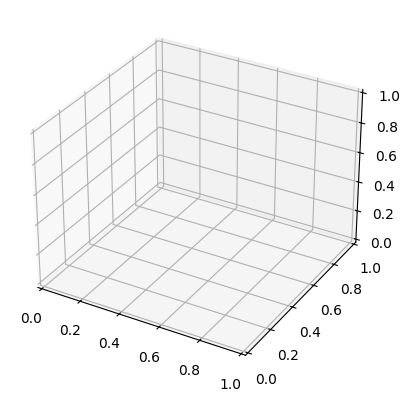

In [ ]:
# 3d plot the sae directions in pca space colored by cluster with legend
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i in range(6):
    cluster = sae_pca_transformed[sae_clusters == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f"Cluster {i}")
ax.legend()
plt.show()

In [ ]:
# count the number of directions in each cluster
for i in range(6):
    print(f"Cluster {i}: {np.sum(sae_clusters == i)} directions")

Cluster 0: 877 directions
Cluster 1: 9601 directions
Cluster 2: 546 directions
Cluster 3: 1901 directions
Cluster 4: 900 directions
Cluster 5: 2559 directions
